In [1]:
import tensorflow
import matplotlib
import seaborn 
import numpy 
import pandas
import sklearn

print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.6.0
3.4.3
0.11.2
1.21.4
1.3.3
1.0


In [16]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [3]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

---
## 가설 설정

### 1. 각 모델은 num_words의 값이 너무 크면 과대적합이, 너무 작으면 과소적합이 발생하여 적절한 값의 num_words를 찾아야 최적의 적합모델이 학습될 것이다.

### 2. 최적의 num_words 값은 각자 다르지만, 대체적으로 위 가설의 큰 형태에서 벗어나지 않을 것이다.


---

In [40]:
from tqdm import tqdm

num_words_list = [5000, 10000, 20000, None]
c_values = [0.01, 0.1, 1, 10, 100, 1000]
results = []
pbar = tqdm(num_words_list, desc="num_words 실험 진행 중")
for num_words in pbar:
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

    ######
    word_index = reuters.get_word_index(path="reuters_word_index.json")
    index_to_word = { index+3 : word for word, index in word_index.items() }
    ###########
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index]=token
    
    decoded_train = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded_train.append(t)

    x_train = decoded_train

    decoded_test = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded_test.append(t)

    x_test = decoded_test
    
    #############
    
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train)

    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

    #############
    
    x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
    tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
    
    inner = tqdm(c_values, leave=False, desc=f"C sweep (num_words={num_words})")
    for c in inner:
        model = LinearSVC(C=c, penalty='l1', dual=False, max_iter=5000, random_state=0)
        model.fit(tfidfv, y_train)
        pred = model.predict(tfidfv_test)
        acc = accuracy_score(y_test, pred)
        f1_macro = f1_score(y_test, pred, average='macro')
        f1_weighted = f1_score(y_test, pred, average='weighted')

        results.append({
            'num_words': str(num_words),
            'C': c,
            'accuracy': acc,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
        })
        inner.set_postfix(C=c, acc=acc, f1=f1)

C sweep (num_words=5000):  50%|█████     | 3/6 [00:16<00:20,  6.88s/it, C=1, acc=0.839, f1=0.664]/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(

C sweep (num_words=5000):  67%|██████▋   | 4/6 [01:59<01:29, 44.96s/it, C=10, acc=0.789, f1=0.664]/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(

C sweep (num_words=5000):  83%|████████▎ | 5/6 [04:02<01:13, 73.25s/it, C=100, acc=0.776, f1=0.664]/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(

C sweep (num_words=10000):  50%|█████     | 3/6 [00:14<00:18,  6.22s/it, C=1, acc=0.838, f1=0.664]/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear faile

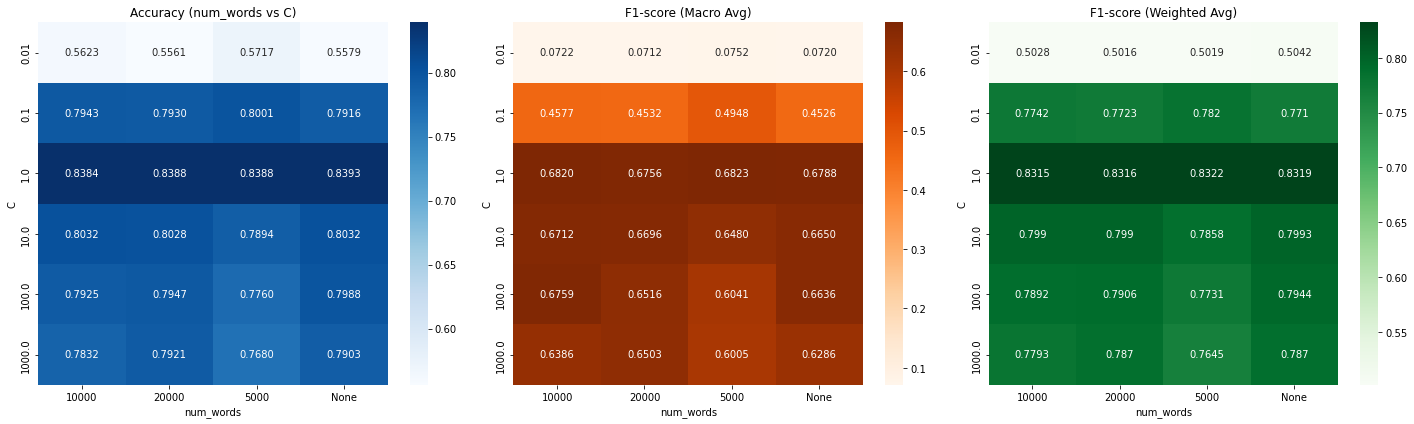

In [41]:
# 데이터프레임 변환
df = pd.DataFrame(results)

# num_words를 정렬 가능하게 처리 (None -> inf)
df['num_words_sort'] = df['num_words'].apply(lambda x: float('inf') if x == 'None' else int(x))
df = df.sort_values(by=['num_words_sort', 'C'])

# 피벗 테이블 생성
pivot_acc = df.pivot(index='C', columns='num_words', values='accuracy')
pivot_f1_macro = df.pivot(index='C', columns='num_words', values='f1_macro')
pivot_f1_weighted = df.pivot(index='C', columns='num_words', values='f1_weighted')

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy heatmap
sns.heatmap(pivot_acc, annot=True, fmt=".4f", cmap="Blues", ax=axes[0])
axes[0].set_title("Accuracy (num_words vs C)")
axes[0].set_xlabel("num_words")
axes[0].set_ylabel("C")

# F1 Macro heatmap
sns.heatmap(pivot_f1_macro, annot=True, fmt=".4f", cmap="Oranges", ax=axes[1])
axes[1].set_title("F1-score (Macro Avg)")
axes[1].set_xlabel("num_words")
axes[1].set_ylabel("C")

# F1 Weighted heatmap
sns.heatmap(pivot_f1_weighted, annot=True, fmt=".4", cmap="Greens", ax=axes[2])
axes[2].set_title("F1-score (Weighted Avg)")
axes[2].set_xlabel("num_words")
axes[2].set_ylabel("C")

plt.tight_layout()
plt.show()

---
### SVM의 경우 C=1일 때, num_words=5000일 때 최고의 결과가 나옴.

c=1, num_words=10000일 때는 f1-score가 0.001만큼 낮음.

---

In [37]:
num_words_list = [5000, 10000, 20000, None]
max_depth_values = [20, 40, 60, 80, 100, 200, 500, 1000]
results = []
pbar = tqdm(num_words_list, desc="num_words 실험 진행 중")
for num_words in pbar:
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

    ######
    word_index = reuters.get_word_index(path="reuters_word_index.json")
    index_to_word = { index+3 : word for word, index in word_index.items() }
    ###########
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index]=token
    
    decoded_train = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded_train.append(t)

    x_train = decoded_train

    decoded_test = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded_test.append(t)

    x_test = decoded_test
    
    #############
    
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train)

    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

    #############
    
    x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
    tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
    
    inner = tqdm(max_depth_values, leave=False, desc=f"max_depth sweep (num_words={num_words})")
    for md in inner:
        model = DecisionTreeClassifier(max_depth=md, random_state=0)  # max_depth는 상황에 맞게 조정
        model.fit(tfidfv, y_train)
        pred = model.predict(tfidfv_test)
        acc = accuracy_score(y_test, pred)
        f1_macro = f1_score(y_test, pred, average='macro')
        f1_weighted = f1_score(y_test, pred, average='weighted')
        results.append({
            'num_words': str(num_words),
            'max_depth': str(md),
            'accuracy': acc,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
        })
        inner.set_postfix(max_depth=md, acc=acc, f1=f1)

num_words 실험 진행 중: 100%|██████████| 4/4 [03:09<00:00, 47.43s/it]                                                    


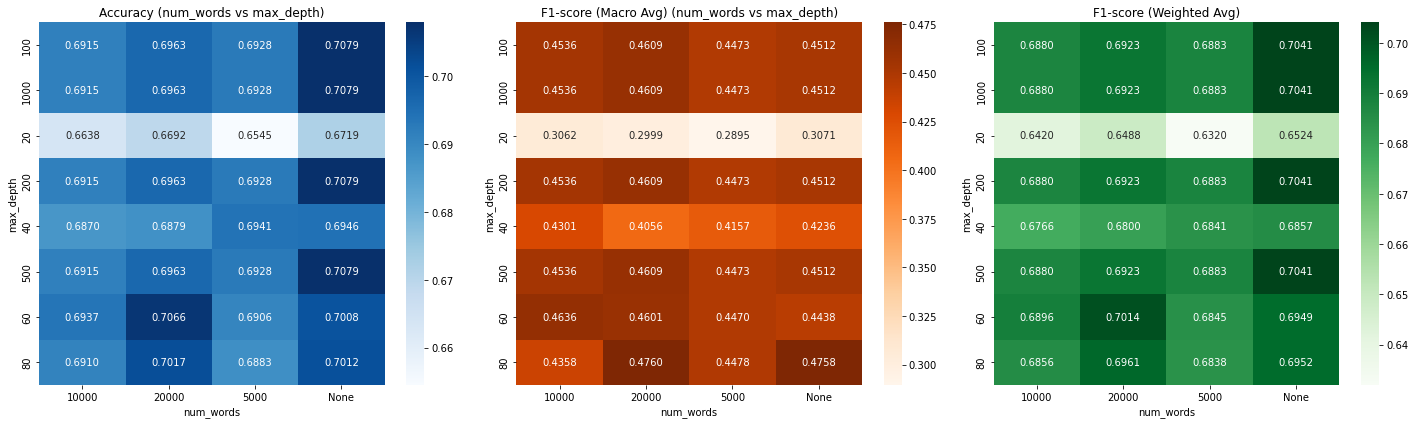

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.DataFrame(results)

pivot_acc = df.pivot(index='max_depth', columns='num_words', values='accuracy')
pivot_f1_macro = df.pivot(index='max_depth', columns='num_words', values='f1_macro')
pivot_f1_weighted = df.pivot(index='max_depth', columns='num_words', values='f1_weighted')

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(pivot_acc, annot=True, fmt=".4f", cmap="Blues", ax=axes[0])
axes[0].set_title("Accuracy (num_words vs max_depth)")
axes[0].set_xlabel("num_words")
axes[0].set_ylabel("max_depth")

sns.heatmap(pivot_f1_macro, annot=True, fmt=".4f", cmap="Oranges", ax=axes[1])
axes[1].set_title("F1-score (Macro Avg) (num_words vs max_depth)")
axes[1].set_xlabel("num_words")
axes[1].set_ylabel("max_depth")

sns.heatmap(pivot_f1_weighted, annot=True, fmt=".4f", cmap="Greens", ax=axes[2])
axes[2].set_title("F1-score (Weighted Avg)")
axes[2].set_xlabel("num_words")
axes[1].set_ylabel("max_depth")

plt.tight_layout()
plt.show()

---
### 결정 트리의 경우 max_depth=80, num_words=20000~None일 때 f1-score의 값이 가장 크고,

### max_depth=100~1000, num_words=None 일 때 accuracy의 값이 가장 큼을 알 수 있음.
---

SVM에 비해 결정트리의 acc, f1-score 모두 성능이 떨어짐을 알 수 있음.

가장 좋은 성능을 보이는 num_words도 SVM은 5000, 결정트리는 20000 이상이라는 차이가 발생함.

-> SVM은 상위 5000개 단어로도 충분히 클래스 간 구분에 필요한 정보가 확보됨.
-> 일부 희귀 단어를 추가로 사용하지 않아도 SVM의 결정 경계에 큰 변화가 없었다.
-> l1 정규화로 분류에 도움되지 않는 단어의 가중치를 0으로 설정한 것도 주요 원인.

-> 결정트리는 많은 단어가 주어질수록 새로운 분할 기준을 찾아 오류를 줄임.
-> 희귀 단어를 사용하여 일부 클래스에 대한 정밀도를 높이는 과정이 진행됨.




In [90]:
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1

num_words_list = [5000, 10000, 20000, None]
results = []
pbar = tqdm(num_words_list, desc="num_words 실험 진행 중")
for num_words in pbar:
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

    ######
    word_index = reuters.get_word_index(path="reuters_word_index.json")
    index_to_word = { index+3 : word for word, index in word_index.items() }
    ###########
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index]=token
    
    decoded_train = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded_train.append(t)

    x_train = decoded_train

    decoded_test = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded_test.append(t)

    x_test = decoded_test
    
    #############
    
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train)

    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

    #############
    
    x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
    tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
    
    tfidfv = tfidfv.toarray()
    tfidfv_test = tfidfv_test.toarray()
    
    num_classes = len(set(y_train))
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    
    
    model = Sequential([
        Dense(512, activation='relu', input_shape=(tfidfv.shape[1],), kernel_regularizer=l1(1e-4)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l1(1e-4)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l1(1e-4)),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(tfidfv, y_train, epochs=20)
    y_test_labels = np.argmax(y_test, axis=1)
    pred = model.predict(tfidfv_test)
    pred_labels = np.argmax(pred, axis=1)
    acc = accuracy_score(y_test_labels, pred_labels)
    f1_macro = f1_score(y_test_labels, pred_labels, average='macro')
    f1_weighted = f1_score(y_test_labels, pred_labels, average='weighted')
    results.append({
        'num_words': str(num_words),
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'history': history
    })
    pbar.set_postfix(acc=acc, f1=f1)

num_words 실험 진행 중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20
281/281 [==============================] - 2s 4ms/step - loss: 4.4146 - accuracy: 0.6764
Epoch 2/20
281/281 [==============================] - 1s 4ms/step - loss: 3.4993 - accuracy: 0.8151
Epoch 3/20
281/281 [==============================] - 1s 4ms/step - loss: 3.1012 - accuracy: 0.8494
Epoch 4/20
281/281 [==============================] - 1s 4ms/step - loss: 2.8840 - accuracy: 0.8650
Epoch 5/20
281/281 [==============================] - 1s 4ms/step - loss: 2.7432 - accuracy: 0.8752
Epoch 6/20
281/281 [==============================] - 1s 4ms/step - loss: 2.6519 - accuracy: 0.8743
Epoch 7/20
281/281 [==============================] - 1s 4ms/step - loss: 2.5299 - accuracy: 0.8821
Epoch 8/20
281/281 [==============================] - 1s 4ms/step - loss: 2.5319 - accuracy: 0.8803
Epoch 9/20
281/281 [==============================] - 1s 4ms/step - loss: 2.4311 - accuracy: 0.8849
Epoch 10/20
281/281 [==============================] - 1s 4ms/step - loss: 2.4096 - accuracy: 0.8832

num_words 실험 진행 중:  25%|██▌       | 1/4 [00:28<01:25, 28.39s/it, acc=0.811, f1=0.651]

Epoch 1/20
281/281 [==============================] - 2s 5ms/step - loss: 4.5722 - accuracy: 0.6879
Epoch 2/20
281/281 [==============================] - 1s 5ms/step - loss: 3.8877 - accuracy: 0.8213
Epoch 3/20
281/281 [==============================] - 2s 5ms/step - loss: 3.4860 - accuracy: 0.8558
Epoch 4/20
281/281 [==============================] - 1s 5ms/step - loss: 3.2706 - accuracy: 0.8700
Epoch 5/20
281/281 [==============================] - 1s 5ms/step - loss: 3.0967 - accuracy: 0.8814
Epoch 6/20
281/281 [==============================] - 1s 5ms/step - loss: 2.9970 - accuracy: 0.8833
Epoch 7/20
281/281 [==============================] - 1s 5ms/step - loss: 2.9560 - accuracy: 0.8841
Epoch 8/20
281/281 [==============================] - 1s 5ms/step - loss: 2.8557 - accuracy: 0.8900
Epoch 9/20
281/281 [==============================] - 1s 5ms/step - loss: 2.7790 - accuracy: 0.8899
Epoch 10/20
281/281 [==============================] - 1s 5ms/step - loss: 2.7890 - accuracy: 0.8888

num_words 실험 진행 중:  50%|█████     | 2/4 [01:01<01:02, 31.42s/it, acc=0.814, f1=0.651]

Epoch 1/20
281/281 [==============================] - 3s 7ms/step - loss: 4.7649 - accuracy: 0.6982
Epoch 2/20
281/281 [==============================] - 2s 7ms/step - loss: 4.3012 - accuracy: 0.8224
Epoch 3/20
281/281 [==============================] - 2s 7ms/step - loss: 3.8925 - accuracy: 0.8629
Epoch 4/20
281/281 [==============================] - 2s 7ms/step - loss: 3.6099 - accuracy: 0.8789
Epoch 5/20
281/281 [==============================] - 2s 7ms/step - loss: 3.4935 - accuracy: 0.8827
Epoch 6/20
281/281 [==============================] - 2s 7ms/step - loss: 3.4055 - accuracy: 0.8903
Epoch 7/20
281/281 [==============================] - 2s 7ms/step - loss: 3.3869 - accuracy: 0.8877
Epoch 8/20
281/281 [==============================] - 2s 7ms/step - loss: 3.2761 - accuracy: 0.8919
Epoch 9/20
281/281 [==============================] - 2s 7ms/step - loss: 3.1906 - accuracy: 0.8901
Epoch 10/20
281/281 [==============================] - 2s 7ms/step - loss: 3.1836 - accuracy: 0.8927

num_words 실험 진행 중:  75%|███████▌  | 3/4 [01:46<00:37, 37.27s/it, acc=0.809, f1=0.651]

Epoch 1/20
281/281 [==============================] - 3s 8ms/step - loss: 4.9399 - accuracy: 0.6885
Epoch 2/20
281/281 [==============================] - 2s 8ms/step - loss: 4.4837 - accuracy: 0.8300
Epoch 3/20
281/281 [==============================] - 2s 9ms/step - loss: 4.1033 - accuracy: 0.8612
Epoch 4/20
281/281 [==============================] - 2s 9ms/step - loss: 3.7421 - accuracy: 0.8794
Epoch 5/20
281/281 [==============================] - 2s 9ms/step - loss: 3.6885 - accuracy: 0.8830
Epoch 6/20
281/281 [==============================] - 2s 9ms/step - loss: 3.5663 - accuracy: 0.8866
Epoch 7/20
281/281 [==============================] - 2s 9ms/step - loss: 3.4667 - accuracy: 0.8908
Epoch 8/20
281/281 [==============================] - 2s 8ms/step - loss: 3.3322 - accuracy: 0.8946
Epoch 9/20
281/281 [==============================] - 2s 8ms/step - loss: 3.3438 - accuracy: 0.8933
Epoch 10/20
281/281 [==============================] - 2s 8ms/step - loss: 3.2756 - accuracy: 0.8942

num_words 실험 진행 중: 100%|██████████| 4/4 [02:42<00:00, 40.66s/it, acc=0.814, f1=0.651]


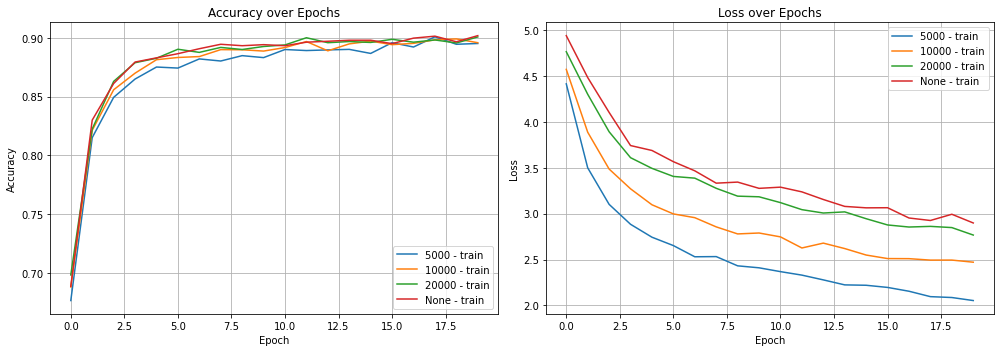

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df = pd.DataFrame(results)

for result in results:
    num_words = result['num_words']
    history = result['history'].history  # keras의 history 객체 내부 dict

    # accuracy
    axes[0].plot(history['accuracy'], label=f'{num_words} - train')
    if 'val_accuracy' in history:
        axes[0].plot(history['val_accuracy'], linestyle='--', label=f'{num_words} - val')

    # loss
    axes[1].plot(history['loss'], label=f'{num_words} - train')
    if 'val_loss' in history:
        axes[1].plot(history['val_loss'], linestyle='--', label=f'{num_words} - val')

# 그래프 설정
axes[0].set_title('Accuracy over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Loss over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

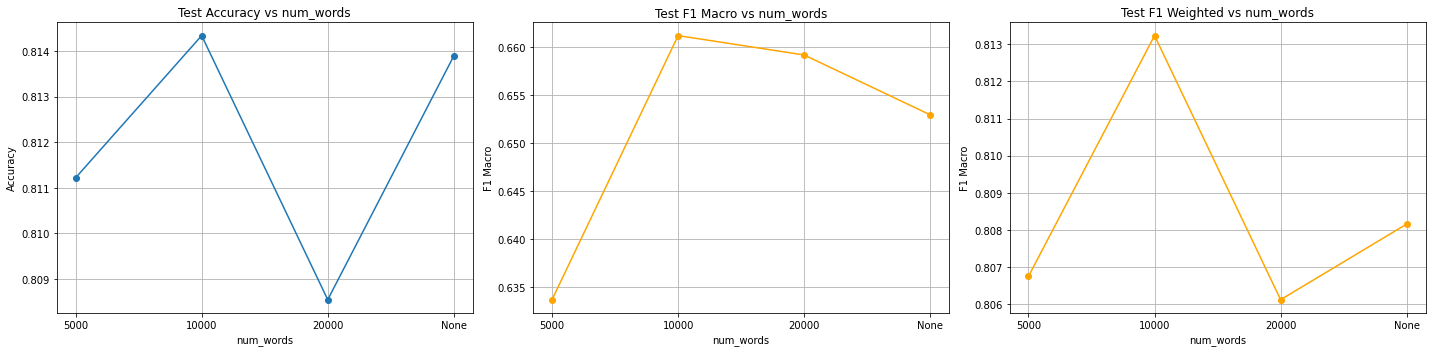

In [93]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Accuracy
axes[0].plot(df['num_words'], df['accuracy'], marker='o', label='Accuracy')
axes[0].set_title('Test Accuracy vs num_words')
axes[0].set_xlabel('num_words')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)

# F1 Macro
axes[1].plot(df['num_words'], df['f1_macro'], marker='o', color='orange', label='F1 Macro')
axes[1].set_title('Test F1 Macro vs num_words')
axes[1].set_xlabel('num_words')
axes[1].set_ylabel('F1 Macro')
axes[1].grid(True)

# F1 Weighted
axes[2].plot(df['num_words'], df['f1_weighted'], marker='o', color='orange', label='F1 Macro')
axes[2].set_title('Test F1 Weighted vs num_words')
axes[2].set_xlabel('num_words')
axes[2].set_ylabel('F1 Macro')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [94]:
df

,num_words,accuracy,f1_macro,f1_weighted,history
0,5000,0.811220,0.633668,0.806747,<keras.callbacks.History object at 0x79117da2e...
1,10000,0.814337,0.661167,0.813234,<keras.callbacks.History object at 0x791180e50...
2,20000,0.808549,0.659148,0.806118,<keras.callbacks.History object at 0x79116c386...
3,None,0.813891,0.652916,0.808156,<keras.callbacks.History object at 0x79117f953...


| 모델             | num_words = 5000    | num_words = 10000   | num_words = 20000   | num_words = None    |
|:-----------------|:--------------------|:--------------------|:--------------------|:--------------------|
| 나이브 베이즈 | macro F1: 0.1102<br>weighted F1: 0.6013<br>accuracy: 0.6732 | macro F1: 0.0967<br>weighted F1: 0.5764<br>accuracy: 0.6567 | macro F1: 0.0789<br>weighted F1: 0.5315<br>accuracy: 0.6193 | macro F1: 0.0677<br>weighted F1: 0.5046<br>accuracy: 0.5997 |
| 서포트 벡터 머신 | macro F1: 0.6823<br>weighted F1: 0.8322<br>accuracy: 0.8388 | macro F1: 0.6820<br>weighted F1: 0.8315<br>accuracy: 0.8384 | macro F1: 0.6756<br>weighted F1: 0.8316<br>accuracy: 0.8388 | macro F1: 0.6788<br>weighted F1: 0.8319<br>accuracy: 0.8393 |
| 로지스틱 | macro F1: 0.4814<br>weighted F1: 0.7762<br>accuracy: 0.7979 | macro F1: 0.4721<br>weighted F1: 0.7732<br>accuracy: 0.7956 | macro F1: 0.4516<br>weighted F1: 0.7671<br>accuracy: 0.7916 | macro F1: 0.4514<br>weighted F1: 0.7670<br>accuracy: 0.7916 |
| CNB | macro F1: 0.4820<br>weighted F1: 0.7459<br>accuracy: 0.7707 | macro F1: 0.4784<br>weighted F1: 0.7457<br>accuracy: 0.7707 | macro F1: 0.4632<br>weighted F1: 0.7391<br>accuracy: 0.7671 | macro F1: 0.4640<br>weighted F1: 0.7347<br>accuracy: 0.7649 |
| 그래디언트 부스팅 트리 | macro F1: 0.5914<br>weighted F1: 0.7688<br>accuracy: 0.7703 | macro F1: 0.5803<br>weighted F1: 0.7699<br>accuracy: 0.7743 | macro F1: 0.5842<br>weighted F1: 0.7649<br>accuracy: 0.7694 | macro F1: 0.5665<br>weighted F1: 0.7648<br>accuracy: 0.7676 |
| 랜덤 포레스트 | macro F1: 0.4470<br>weighted F1: 0.7418<br>accuracy: 0.7640 | macro F1: 0.4292<br>weighted F1: 0.7295<br>accuracy: 0.7538 | macro F1: 0.3793<br>weighted F1: 0.7074<br>accuracy: 0.7355 | macro F1: 0.4066<br>weighted F1: 0.7195<br>accuracy: 0.7458 |
| 결정 트리 | macro F1: 0.4473<br>weighted F1: 0.6883<br>accuracy: 0.6928 | macro F1: 0.4546<br>weighted F1: 0.6880<br>accuracy: 0.6915 | macro F1: 0.4609<br>weighted F1: 0.6923<br>accuracy: 0.6963 | macro F1: 0.4512<br>weighted F1: 0.7041<br>accuracy: 0.7079 |
| 보팅 | macro F1: 0.6009<br>weighted F1: 0.7931<br>accuracy: 0.7961 | macro F1: 0.5999<br>weighted F1: 0.7924<br>accuracy: 0.7970 | macro F1: 0.6029<br>weighted F1: 0.7937<br>accuracy: 0.7988 | macro F1: 0.5952<br>weighted F1: 0.7945<br>accuracy: 0.8001 |
| DNN | macro F1: 0.6336<br>weighted F1: 0.8067<br>accuracy: 0.8112 | macro F1: 0.6611<br>weighted F1: 0.8132<br>accuracy: 0.8143 | macro F1: 0.6591<br>weighted F1: 0.8061<br>accuracy: 0.8085 | macro F1: 0.6529<br>weighted F1: 0.8081<br>accuracy: 0.8138 |

---
### 결과 분석

- SVM은 num_words의 값과 크게 상관 없이 비슷하게 좋은 성능을 보임(강인함)
- DNN은 num_words가 10,000 개 일 때 최고 f1을 기록하고, 이후 과대적합의 경향을 보임.
- 트리/앙상블은 num_words가 너무 크면 희귀 단어에 분기를 과하게 만들어내어 성능 저하를 보임.
- CNB, 로지스틱은 num_words가 작을 때 가장 좋은 성능을 보임.

---

---
### 회고

- 모델마다 과대적합되는 num_words가 다른데, 과소적합되는 부분을 찾기는 어려웠던 것 같다. num_words를 1000으로 설정해서 실험을 다같이 해봤다면 더 좋았을 것 같다.

---